In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

import lsst.sims.maf.db as db
import lsst.sims.maf.utils as utils
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.metricBundles as metricBundles

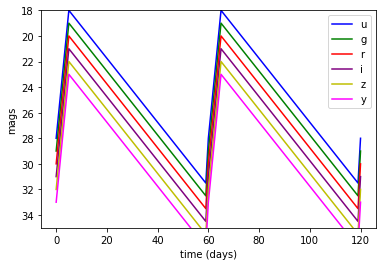

In [2]:
# Let's look at how the transient metric makes light curves
peaks = {'uPeak': 18, 'gPeak': 19, 'rPeak': 20,
         'iPeak': 21, 'zPeak': 22,'yPeak': 23}
colors = ['b', 'g', 'r', 'purple', 'y', 'magenta', 'k']
filterNames = ['u', 'g', 'r', 'i', 'z', 'y']

transDuration = 60. # Days
transMetric = metrics.TransientMetric(
    riseSlope=-2., declineSlope=0.25,
    transDuration=transDuration, peakTime=5., **peaks)


times = np.arange(0., 121, 1) 
for filterName, color in zip(filterNames, colors):
    filters = np.array([filterName]*times.size)
    lc = transMetric.lightCurve(times % transDuration,filters)
    plt.plot(times,lc, color, label=filterName)
plt.xlabel('time (days)')
plt.ylabel('mags')
plt.ylim([35,18])
plt.legend()

In [3]:
# Let's modify the usual transient metric so that it can take dictionaries for things
class ColorTransientMetric(metrics.TransientMetric):
    """Modify TransientMetric so peakTime, riseSlope, declineSlope, and peaks can be dicts
    """
    def __init__(self, metricName='ColorTransientDetectMetric', mjdCol='observationStartMJD',
                 m5Col='fiveSigmaDepth', filterCol='filter',
                 transDuration=10., peakTime=5., riseSlope=0., declineSlope=0., peaks=20., 
                 surveyDuration=10., surveyStart=None, detectM5Plus=0.,
                 nPrePeak=0, nPerLC=1, nFilters=1, nPhaseCheck=1, countMethod='full',
                 **kwargs):
        
        super(ColorTransientMetric, self).__init__(mjdCol=mjdCol, m5Col=m5Col, filterCol=filterCol,
                                                   metricName=metricName, **kwargs)
        filternames = ['u', 'g', 'r', 'i', 'z', 'y']
        if type(peaks) is dict:
            self.peaks = peaks
        else:
            self.peaks = {}
            for key in filternames:
                self.peaks[key] = peaks
        
        if type(peakTime) is dict:
            self.peakTime = peakTime
        else:
            self.peakTime = {}
            for key in filternames:
                self.peakTime[key] = peakTime
        
        if type(riseSlope) is dict:
            self.riseSlope = riseSlope
        else:
            self.riseSlope = {}
            for key in filternames:
                self.riseSlope[key] = riseSlope
        
        if type(declineSlope) is dict:
            self.declineSlope = declineSlope
        else:
            self.declineSlope = {}
            for key in filternames:
                self.declineSlope[key] = declineSlope
        
        self.transDuration = transDuration
        self.surveyDuration = surveyDuration
        self.surveyStart = surveyStart
        self.detectM5Plus = detectM5Plus
        self.nPrePeak = nPrePeak
        self.nPerLC = nPerLC
        self.nFilters = nFilters
        self.nPhaseCheck = nPhaseCheck
        self.countMethod = countMethod
        
    def lightCurve(self, time, filters):
        """
        Calculate the magnitude of the object at each time, in each filter.

        Parameters
        ----------
        time : numpy.ndarray
            The times of the observations.
        filters : numpy.ndarray
            The filters of the observations.

        Returns
        -------
        numpy.ndarray
            The magnitudes of the object at each time, in each filter.
        """
        lcMags = np.zeros(time.size, dtype=float)
        ufilters = np.unique(filters)
        for filtername in ufilters:
            rise = np.where((time <= self.peakTime[filtername]) & (filters == filtername))
            lcMags[rise] += self.riseSlope[filtername] * time[rise] - self.riseSlope[filtername] * self.peakTime[filtername]
            decline = np.where((time > self.peakTime[filtername]) & (filters == filtername))
            try:
                lcMags[decline] += self.declineSlope[filtername] * (time[decline] - self.peakTime[filtername])
            except:
                import pdb ; pdb.set_trace()
            fMatch = np.where(filters == filtername)
            lcMags[fMatch] += self.peaks[filtername]
        return lcMags

In [4]:
dbFile = 'baseline2018a.db'
# This connection checks which version it thinks the database is and should do the right thing schema-wise
conn = db.OpsimDatabase(dbFile)
outDir='temp'
resultsDb = db.ResultsDb(outDir=outDir)

In [9]:
bundleList = []

# The old transient metric
metric = metrics.TransientMetric()
slicer = slicers.HealpixSlicer()
sql = 'night < 365'

bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

# New transient metric, should be the same old one with defaults
metric = ColorTransientMetric()
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

# The new transient metric with all kinds of crazy filter-dependent slopes and peaks
peakTimes = {'u': 2, 'g': 1, 'r': 1, 'i': 1,'z': 6, 'y': 6}
riseSlope= {'u': -1, 'g': -1, 'r': -1, 'i': -2,'z': -5, 'y': -5}
declineSlope= {'u': 10, 'g': 10, 'r': 20, 'i': 20,'z': 20, 'y': 2}
peaks= {'u': 20, 'g': 20, 'r': 21, 'i': 21,'z': 22, 'y': 22}
metric = ColorTransientMetric(peakTime=peakTimes, peaks=peaks, riseSlope=riseSlope, declineSlope=declineSlope,
                             metricName='ColorTrans_varying')
bundleList.append(metricBundles.MetricBundle(metric,slicer,sql))

Healpix slicer using NSIDE=128, approximate resolution 27.483891 arcminutes


Querying database SummaryAllProps with constraint night < 365 for columns ['fiveSigmaDepth', 'filter', 'fieldDec', 'fieldRA', 'observationStartMJD']
Found 233790 visits
Running:  ['opsim_TransientDetectMetric_night_lt_365_HEAL', 'opsim_ColorTransientDetectMetric_night_lt_365_HEAL', 'opsim_ColorTrans_varying_night_lt_365_HEAL']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.
Plotting figures with "night < 365" constraint now.
monopole: 0.0368045  dipole: lon: -81.2983, lat: -60.7211, amp: 0.00693197
monopole: 0.0368045  dipole: lon: -81.2983, lat: -60.7211, amp: 0.00693197
monopole: 0.00848675  dipole: lon: -28.0142, lat: -65.5765, amp: 0.00379041
Plotting complete.


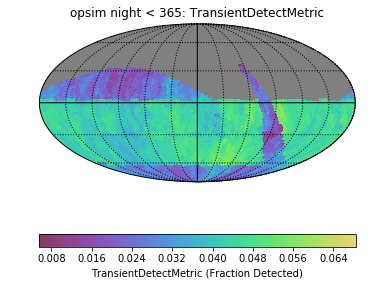

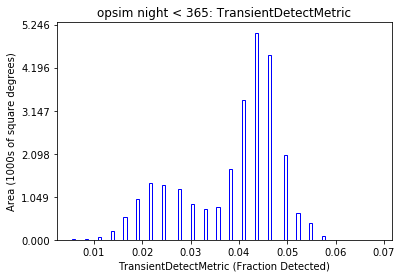

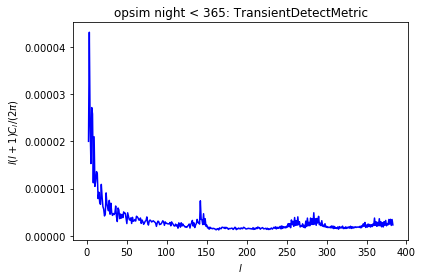

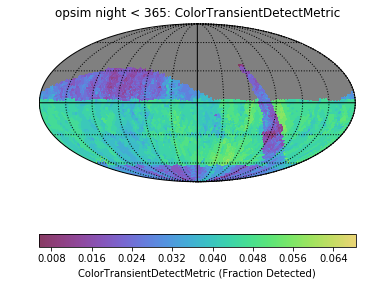

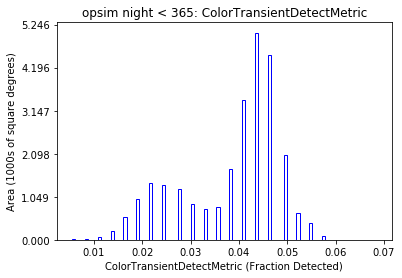

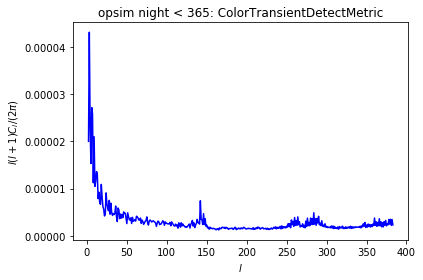

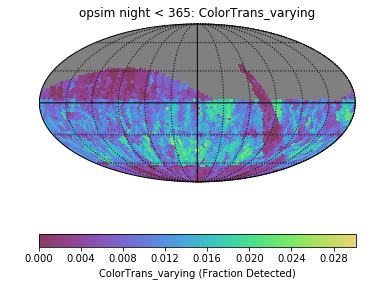

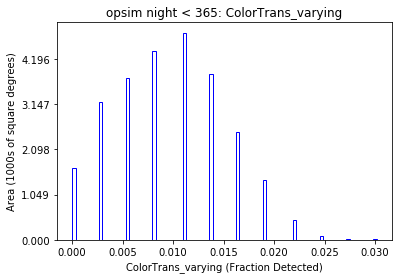

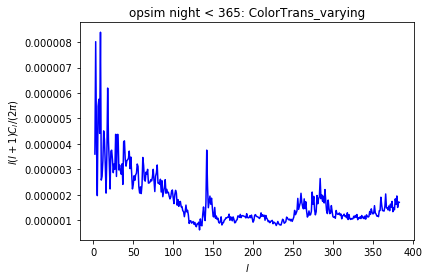

In [11]:
bd = metricBundles.makeBundlesDictFromList(bundleList)
bg = metricBundles.MetricBundleGroup(bd, conn, outDir=outDir, resultsDb=resultsDb)
bg.runAll()
bg.plotAll(closefigs=False)